In [2]:
# 5420 - HW3
# Haoran Yang

In [79]:
# ======================================
# Import Necessary Libraries
# ======================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")


In [80]:
# ======================================
# 1. Data Loading and Initial Processing
# ======================================

# Load the dataset
try:
    df = pd.read_csv("XYZloan_default_selected_vars.csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'XYZloan_default_selected_vars.csv' was not found.")
    # You may need to check the file path or name.
    raise

# Replace -99 with NaN to represent missing values
df.replace(-99, np.nan, inplace=True)
print("Replaced -99 with NaN.")

# Define the variables for analysis
selected_vars = [
    "AP001",
    "AP003",
    "AP008",
    "CR009",
    "CR015",
    "CR019",
    "PA022",
    "PA023",
    "PA029",
    "TD001",
    "TD005",
    "TD006",
    "TD009",
    "TD010",
    "TD014",
    "loan_default",
]

# Identify categorical variables (even if they are numeric in the data)
categorical_vars = [
    "AP001",
    "AP003",
    "AP008",
    "CR015",
    "CR019",
    "PA022",
    "PA023",
    "TD001",
    "TD005",
    "TD006",
    "TD009",
    "TD010",
    "TD014",
]

# Variables to be binned (continuous variables)
continuous_vars_to_bin = ["CR009", "PA029"]

# Target variable
target_var = "loan_default"

# Ensure all selected variables are present in the dataframe
missing_vars = [var for var in selected_vars if var not in df.columns]
if missing_vars:
    print(f"Warning: The following variables are missing from the dataset: {missing_vars}")
    # Remove missing variables from selected_vars and other lists
    selected_vars = [var for var in selected_vars if var in df.columns]
    categorical_vars = [var for var in categorical_vars if var in selected_vars]
    continuous_vars_to_bin = [var for var in continuous_vars_to_bin if var in selected_vars]
else:
    print("All selected variables are present in the dataset.")


Data loaded successfully.
Replaced -99 with NaN.
All selected variables are present in the dataset.


In [81]:
# ======================================
# 2. Data Splitting
# ======================================

# Separate features and target
X = df[selected_vars[:-1]]  # All features except the target variable
y = df[target_var]

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")



Training set size: (56000, 15)
Testing set size: (24000, 15)


In [82]:
# ======================================
# 3. Binning Continuous Variables
# ======================================

# Binning continuous variables into categorical bins
for var in continuous_vars_to_bin:
    if var in X_train.columns:
        print(f"Binning variable '{var}'.")
        # Create binned variables in the training set
        X_train[f"{var}_binned"], bins = pd.qcut(
            X_train[var], q=5, duplicates="drop", retbins=True
        )
        # Apply the same bins to the test set
        X_test[f"{var}_binned"] = pd.cut(
            X_test[var], bins=bins, include_lowest=True
        )
        # Drop the original continuous variable
        X_train.drop(columns=[var], inplace=True)
        X_test.drop(columns=[var], inplace=True)
        # Add the binned variable to categorical_vars
        categorical_vars.append(f"{var}_binned")
    else:
        print(f"Warning: '{var}' not found in X_train columns. Skipping binning for this variable.")

# Remove continuous variables that were binned from selected_vars
selected_vars = [var for var in selected_vars if var not in continuous_vars_to_bin]

print("Binning completed.")


Binning variable 'CR009'.
Binning variable 'PA029'.
Binning completed.


In [83]:
# ======================================
# 4. Missing Value Imputation
# ======================================

# Impute missing values in categorical variables with the most frequent category
print("Imputing missing values for categorical variables.")
categorical_imputer = SimpleImputer(strategy="most_frequent")
X_train[categorical_vars] = categorical_imputer.fit_transform(X_train[categorical_vars])
X_test[categorical_vars] = categorical_imputer.transform(X_test[categorical_vars])

# Ensure that all categorical variables are of type 'category'
for var in categorical_vars:
    X_train[var] = X_train[var].astype("category")
    X_test[var] = X_test[var].astype("category")

print("Missing value imputation completed.")


Imputing missing values for categorical variables.
Missing value imputation completed.


In [84]:
# ======================================
# 5. Handling Variables with Zero Counts in Categories
# ======================================

# Identify variables with categories that have zero counts in one of the target classes
variables_with_zero_counts = []

for var in categorical_vars:
    crosstab = pd.crosstab(X_train[var], y_train)
    if (crosstab == 0).any().any():
        print(f"\nVariable '{var}' has categories with zero counts in one of the target classes.")
        print("Crosstab:")
        print(crosstab)
        variables_with_zero_counts.append(var)
    else:
        print(f"Variable '{var}' has no zero counts in categories.")

if variables_with_zero_counts:
    print("\nVariables with zero counts in categories:", variables_with_zero_counts)
else:
    print("\nNo variables with zero counts in categories.")

# Note: We will handle zero counts during WoE encoding with smoothing


Variable 'AP001' has no zero counts in categories.

Variable 'AP003' has categories with zero counts in one of the target classes.
Crosstab:
loan_default      0     1
AP003                    
1             24533  6969
3             13913  2891
4              6551   970
5               153    12
6                 8     0
Variable 'AP008' has no zero counts in categories.
Variable 'CR015' has no zero counts in categories.
Variable 'CR019' has no zero counts in categories.

Variable 'PA022' has categories with zero counts in one of the target classes.
Crosstab:
loan_default      0     1
PA022                    
-1.0          30499  6274
 0.0             80    24
 1.0            103    46
 2.0            114    31
 3.0             91    31
...             ...   ...
 437.0            1     0
 440.0            1     0
 441.0            1     0
 445.0            0     1
 448.0            1     0

[163 rows x 2 columns]

Variable 'PA023' has categories with zero counts in one of the target c

In [85]:
# ======================================
# 6. WoE Encoding with Smoothing
# ======================================

# Define a function to calculate WoE with smoothing to handle zero counts
def calculate_woe_smoothing(data, feature, target, epsilon=0.5):
    temp = data.groupby(feature)[target].agg(["count", "sum"])
    temp.columns = ["Total", "Events"]
    temp["Non-Events"] = temp["Total"] - temp["Events"]
    # Apply smoothing by adding epsilon
    temp["Events"] += epsilon
    temp["Non-Events"] += epsilon
    # Calculate distributions
    temp["Dist_Events"] = temp["Events"] / temp["Events"].sum()
    temp["Dist_Non_Events"] = temp["Non-Events"] / temp["Non-Events"].sum()
    # Calculate WoE
    temp["WoE"] = np.log(temp["Dist_Non_Events"] / temp["Dist_Events"])
    return temp["WoE"].to_dict()

# Combine X_train and y_train for WoE calculation
train_data = pd.concat([X_train, y_train], axis=1)

# Apply the custom WoE encoding with smoothing to all categorical variables
print("\nApplying WoE encoding with smoothing.")
for var in categorical_vars:
    print(f"Processing variable '{var}'.")
    # Calculate WoE with smoothing
    woe_map = calculate_woe_smoothing(train_data, var, target_var)
    # Map the WoE values to the training and testing data
    X_train[var] = X_train[var].map(woe_map)
    X_test[var] = X_test[var].map(woe_map)
    # Convert variables to float type
    X_train[var] = X_train[var].astype(float)
    X_test[var] = X_test[var].astype(float)
    # Fill any NaN values in X_test resulting from unseen categories with zero
    X_test[var] = X_test[var].fillna(0)

print("WoE encoding completed.")



Applying WoE encoding with smoothing.
Processing variable 'AP001'.
Processing variable 'AP003'.
Processing variable 'AP008'.
Processing variable 'CR015'.
Processing variable 'CR019'.
Processing variable 'PA022'.
Processing variable 'PA023'.
Processing variable 'TD001'.
Processing variable 'TD005'.
Processing variable 'TD006'.
Processing variable 'TD009'.
Processing variable 'TD010'.
Processing variable 'TD014'.
Processing variable 'CR009_binned'.
Processing variable 'PA029_binned'.
WoE encoding completed.



Training Logistic Regression model.
Model training completed.

ROC AUC Score: 0.6562

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89     19354
           1       0.44      0.01      0.02      4646

    accuracy                           0.81     24000
   macro avg       0.63      0.50      0.45     24000
weighted avg       0.74      0.81      0.72     24000



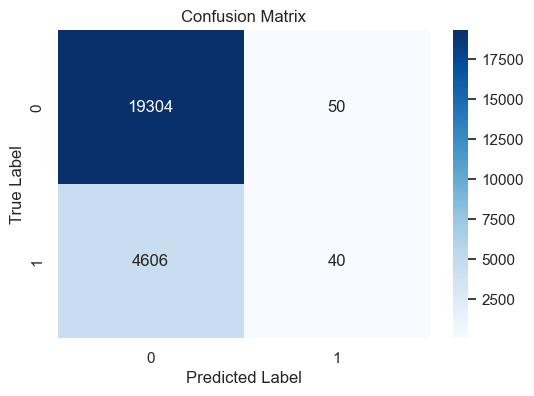

In [86]:
# ======================================
# 7. Model Training and Evaluation
# ======================================

# Initialize the Logistic Regression model
print("\nTraining Logistic Regression model.")
model = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)
print("Model training completed.")

# Predict probabilities on the test data
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {auc_score:.4f}")

# Predict class labels on the test data
y_pred = model.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


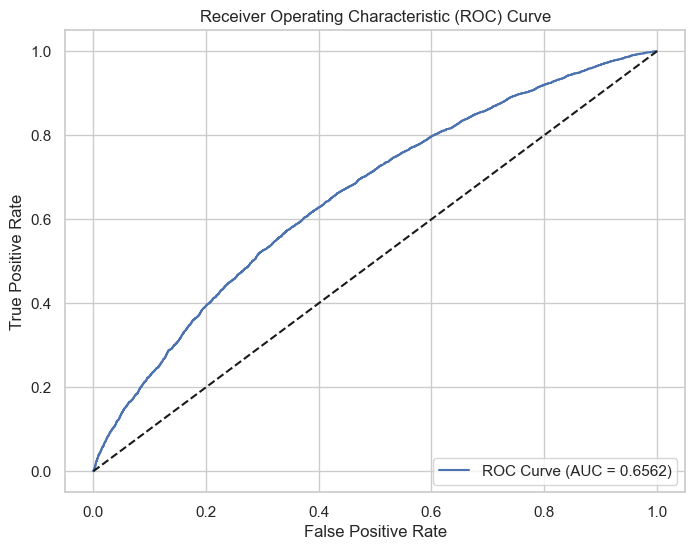

In [87]:
# ======================================
# 8. Plot ROC Curve
# ======================================

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], "k--")  # Diagonal line for reference
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()
